In [1]:
%config IPCompleter.greedy=True
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

sns.set(style="darkgrid")

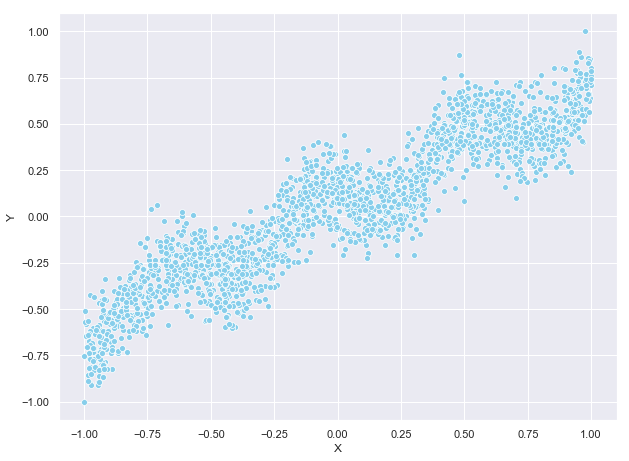

In [2]:
dataset = "data_regression1.txt"
df = pd.read_csv(dataset,delimiter=',',header=None,names=['feature','output'])

X1 = df['feature'].values.reshape(-1,1)
Y1 = df['output'].values.reshape(-1,1)

scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
X1 = scaler.fit_transform(X1)
Y1 = scaler.fit_transform(Y1)

fig = plt.figure(figsize=(10,7.5))
ax = sns.scatterplot(x=X1.ravel(),y=Y1.ravel(),color='skyblue')

plt.xlabel('X')
plt.ylabel('Y')
plt.show()

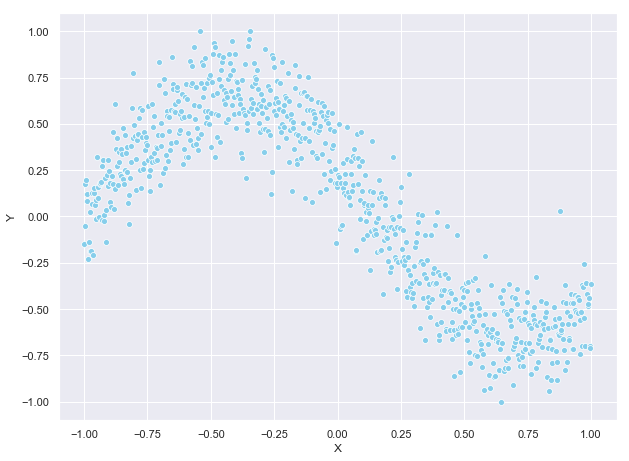

In [3]:
number_of_items = 750
noise = 0.5
freq = 1.75
X2 = np.linspace(0,freq*np.pi,number_of_items)
Y2 = np.sin(X2) * 2
n = np.random.rand(number_of_items)
n = np.random.normal(0, 1, number_of_items) * noise
Y2 = Y2 + n

X2 = scaler.fit_transform(X2.reshape(-1,1))
Y2 = scaler.fit_transform(Y2.reshape(-1,1))
X2 = X2.reshape(number_of_items,1)
Y2 = Y2.reshape(number_of_items,1)

fig = plt.figure(figsize=(10,7.5))
ax = sns.scatterplot(x=X2.ravel(),y=Y2.ravel(),color='skyblue')

plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [4]:
class Layer(object):
    def __init__(self):
        pass
    
    def compile(self):
        pass
    
    def activate(self,x):
        pass

class InputLayer(Layer):
    def __init__(self,input_dim):
        self.input_dim = input_dim
        self.units = input_dim
        self.name = "InputLayer"
    
    def activate(self,x):
        self.lastActivation = x
        return x
    
class DenseLayer(Layer):
    def __init__(self,units,activation='relu',name="DenseLayer"):
        self.weights = []
        self.bias = None
        self.units = units
        self.input_dim = 0
        self.name = name
        self.activation = activation
        self.velocity = 0
            
    def compile(self):
        # Create weights
        #self.weights = np.random.randn(self.input_dim,self.units)
        self.weights = np.random.normal(0, 1, size=(self.input_dim,self.units)) * 2/self.input_dim
        self.bias = 0.01
            
    def activate(self,x):
        o = np.dot(x,self.weights) + self.bias
        if(self.activation == 'relu'):
            o = self.relu(o)
        elif(self.activation == 'sigmoid'):
            o = self.sigmoid(o)
        elif(self.activation == 'lu'):
            o = self.lu(o)
        elif(self.activation == 'lrelu'):
            o = self.leakyrelu(o)
        self.lastActivation = o
        return o
    
    def get_gradient(self,output):
        if(self.activation == 'relu'):
            return self.relu_grad(output)
        elif(self.activation == 'sigmoid'):
            return self.sigmoid_grad(output)
        elif(self.activation == 'lu'):
            return self.lu_grad(output)
        elif(self.activation == 'lrelu'):
            return self.lrelu_grad(output)
        
    def sigmoid(self,x):
        return 1.0 / (1.0 + np.exp(-x))
    def relu(self,x):
        return np.maximum(0,x)
    def leakyrelu(self,x):
        return np.where(x > 0, x, x * 0.01)
    def lu(self,x):
        return x

    def sigmoid_grad(self,output):
        return output * (1.0 - output)
    def lu_grad(self,output):
        return 1
    def relu_grad(self,output):
        return np.greater(output, 0).astype(int)
    def lrelu_grad(self,output):
        y = np.less(output,0)
        c = output.copy()
        c[y] = 0.01
        c[~y] = 1
        return c

In [5]:
class Model():
    def __init__(self,lr = 0.001,momentum=0.9):
        self.layers = []
        self.layerCount = 0
        self.lr = lr
        self.momentum = momentum
        
    def Add(self,layer):
        if(not isinstance(layer,Layer)):
            raise Exception("Parameter should be type of Layer.")
        
        if(self.layerCount == 0 and not isinstance(layer,InputLayer)):
            raise Exception("First Layer should be type of Input Layer.")
        
        self.layers.append(layer)
        self.layerCount += 1
        
    def compile(self):
        # Infer layer input dimensions
        for i in range(1,self.layerCount):
            dim = self.layers[i - 1].units
            self.layers[i].input_dim = dim
            self.layers[i].compile()
    
    def train(self,X,y,epoch = 10):  
        history = pd.DataFrame({'epoch':[None],'loss':[None]})

        for e in range(0,epoch):
            loss = self.backPropagate(X,y)
            if(e > 2):
                history.loc[history.shape[0]] = [e,loss]
            if(e % 40 == 0 or e==epoch-1):
                print(f'Epoch: {e}, mse: {loss}')        
        return history

    def predict(self,x):
        return self.feedForward(x)
        
    def feedForward(self,x):
        for layer in self.layers:
            x = layer.activate(x)
        return np.array(x)
    
    def backPropagate(self,x,y):
        output_layer = self.layers[-1]
        
        output = self.feedForward(x) # Network Output
        output_error = y - output # Output Error (y - pred)
        self.layers[-1].delta = (output_error * output_layer.get_gradient(output)) # df * error

        for i in range(self.layerCount - 2,0,-1):
            nextLayer = self.layers[i +  1]
            currentLayer = self.layers[i]
            
            error = np.dot(nextLayer.delta,nextLayer.weights.T)
            gradient = currentLayer.get_gradient(currentLayer.lastActivation)
            delta = error * gradient
            self.layers[i].delta = delta 

        # Update Weights
        for i in range(1,self.layerCount):
            d = self.layers[i].delta
            w = self.layers[i].weights
            v = self.layers[i].velocity
            
            o = np.dot(self.layers[i-1].lastActivation.T,d)
            
            self.layers[i].velocity = (self.momentum * v) + (self.lr * o) # SGD Momentum
            self.layers[i].weights += self.layers[i].velocity
            self.layers[i].bias += self.lr * np.sum(self.layers[i].delta)
        
        return np.mean(np.square(output_error))

Epoch: 0, mse: 0.1544138679099378
Epoch: 40, mse: 0.0218671437870899
Epoch: 80, mse: 0.02170392955307067
Epoch: 120, mse: 0.02158169507698383
Epoch: 160, mse: 0.021450848909296542
Epoch: 200, mse: 0.021304286764145048
Epoch: 240, mse: 0.021173814216305296
Epoch: 280, mse: 0.02106089672895714
Epoch: 320, mse: 0.02095902321072719
Epoch: 360, mse: 0.020845758304447102
Epoch: 400, mse: 0.020640679639981393
Epoch: 440, mse: 0.020364845892684426
Epoch: 480, mse: 0.019996123222193435
Epoch: 499, mse: 0.0197527256272364


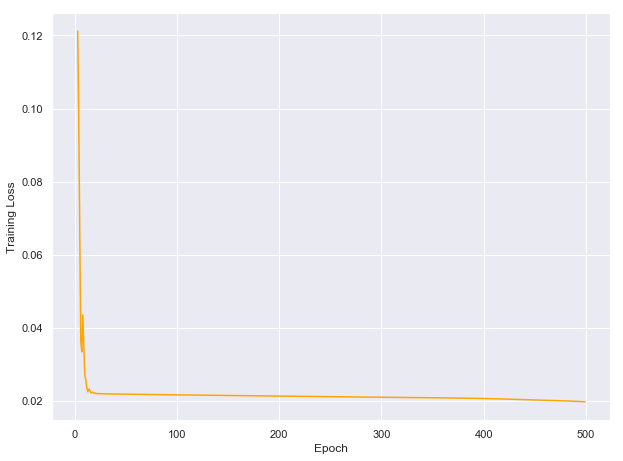

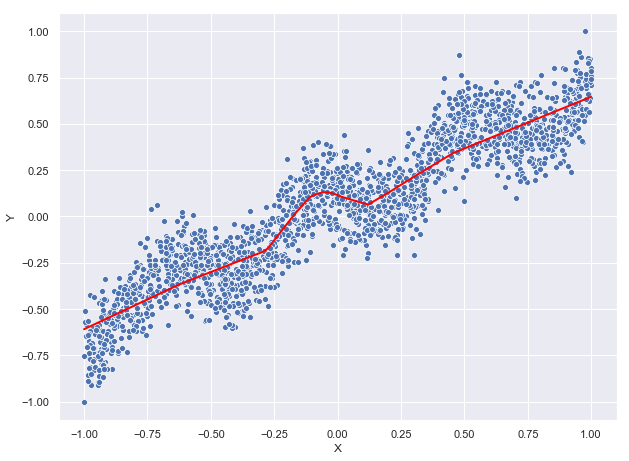

In [29]:
m = Model(lr=0.0002)

m.Add(InputLayer(input_dim=1))

m.Add(DenseLayer(32,activation='relu',name="L_1"))
m.Add(DenseLayer(32,activation='relu',name="L_2"))
m.Add(DenseLayer(32,activation='relu',name="L_2"))

m.Add(DenseLayer(1,activation='lu',name="OutputLayer"))

m.compile()

x_train = X1
y_train = Y1
epoch = 500

history = m.train(x_train,y_train,epoch)
fig = plt.figure(figsize=(10,7.5))
ax = sns.lineplot(x='epoch',y='loss',color='orange',data=history)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

pred = m.predict(x_train).ravel()
fit = pd.DataFrame()
fit['pred'] = pred
fit['x'] = x_train
fit['y'] = y_train

fig = plt.figure(figsize=(10,7.5))
sns.scatterplot(x_train.ravel(),y_train.ravel())
ax = sns.lineplot(x='x',y='pred',color='red',data=fit,linewidth=2.0)

plt.xlabel('X')
plt.ylabel('Y')
plt.show()